In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
# make matplotlib plots appear inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10 ############################ <-Use this to change the plot
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }</style>")
import pulp
from pulp import *
from qpsolvers import solve_qp
import scipy as sp
from math_utils import *
from FW1 import frank_wolfe1
from FW2 import *
import pickle

ModuleNotFoundError: No module named 'math_utils'

In [357]:
n = 200
m = 40

A = np.random.binomial(1, 0.5, size=((m, n)))
b = 0.5 * A.dot(np.ones(n))

x_star = solve_relaxed_problem(A, b)

In [364]:
cost(x_star), cost_relaxed(x_star), x_star, A@x_star - b

(111,
 89.074572488,
 array([1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.25314872, 0.76199176, 1.        ,
        0.88320062, 0.        , 0.        , 1.        , 0.        ,
        0.77386401, 0.        , 1.        , 1.        , 0.156905  ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.17266862, 1.        ,
        0.55428906, 0.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.77629936, 1.        ,
        0.        , 0.        , 0.78857582, 0.870047  , 0.        ,
        0.13931999, 1.        , 1.        , 0.256177  , 0.        ,
        0.7792273 , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.47035485, 0.     

# Get a primal decomposition

In [365]:
def clean_dictionary(y_dic):
    new_dic = {}
    for _, (i, value) in enumerate(y_dic.items()):
        pointer_i = value[1]
        new_array = value[0][:pointer_i]
        new_etas = value[2][:pointer_i]
        new_dic[i] = [new_array, new_etas]
    return new_dic


def frank_wolfe1(x_star,
                 K,
                 A, b, stepsize_needed=True):

    (m, n) = A.shape
    opt_cost_relaxed = cost_relaxed(x_star)
    z_star = np.zeros(1+m)
    z_star[0] = opt_cost_relaxed
    z_star[1:] = b
    
    #Initialize algorithm
    #need to find y_i^1 such that f_i(y_i^1) = f_i^{**}(y_i^1)
    #to do so, maybe we can just optimize any linear function over C'

    x_start = np.zeros(n)
    z_k = np.zeros(1 + m)
    z_k[0] = cost(x_start)
    z_k[1:] = A.dot(x_start)

    print(z_k)

    counter_not_feasible = 0

    y_array = np.zeros((n, K))
    
    pointer = 0
    y_dic = {}
    for i in range(n):
        #y_dic[i] = [np.inf * np.ones((2*m, K)), 1, np.zeros(K), -1]
        #y_dic[i] = [np.zeros((2*m, K)), 1, np.zeros(K), -1]
        y_dic[i] = [np.zeros(1), 1, np.zeros(K), -1]      
        y_dic[i][0][0] = x_start[i]
        y_dic[i][2][0] = 1
    
    for k in range(1, K):

        grad_k = np.clip(z_k - z_star, 0, None)  
        grad_k_0 = grad_k[0]        
        grad_k_rest = grad_k[1:]

        if k%100 == 0 or k==1:
        #if True:
            print(f"Iteration {k} : ||z_k - z*||_+^2 = {np.clip(z_k[0] - opt_cost_relaxed, 0, None)} + {np.linalg.norm(np.clip(z_k[1:] - b, 0, None))}")
            print(f"     ||grad(z_k)|| = {np.sqrt( grad_k_0**2 + np.linalg.norm(grad_k_rest)**2)}")
        
        

        s_k = np.zeros(1 + m)

        y_k = np.zeros(n)

        for i in range(n):
            ATi_dot_gk = A[:, i].dot(grad_k_rest)
            if grad_k_0 > 0:
                ATi_dot_gk = -ATi_dot_gk / grad_k_0
                y_ik = f_conjugate_subgrad(ATi_dot_gk)
            if grad_k_0 == 0:
                if ATi_dot_gk > 0:
                    y_ik = 0
                else:
                    y_ik = 1

            f_bi_value_ik = f_biconjugate_value(y_ik)
            #check that we are at an extreme points where f and its biconjugate match
            f_value_ik = f_value(y_ik)
            if np.abs(f_bi_value_ik - f_value_ik) > 1e-5:
                print("Not at an extreme point")
                return                 
                
            Ati_dot_y_ik = A[:, i].dot(y_ik)
            s_k += np.concatenate(([f_bi_value_ik], Ati_dot_y_ik))
            y_k[i] = y_ik

            
            pointer_i = y_dic[i][1]
            #matching_y_ik = np.where(True == np.all(y_dic[i][0][:pointer_i] == y_ik, axis=0))[0]
            matching_y_ik = np.where(True == (y_dic[i][0][:pointer_i] == y_ik))[0]
            #print(y_ik)
            if matching_y_ik.shape[0] == 0:
                #y_dic[i][0][:, pointer_i] = y_ik
                #print("here")
                y_dic[i][0] = np.concatenate((y_dic[i][0], [y_ik]))
                #print(y_dic[i][0])
                y_dic[i][3] = -1
                y_dic[i][1] += 1
            else:
                y_dic[i][3] = matching_y_ik

            #print("s_k = ",  s_k, ATi_dot_gk)

        if np.any(A.dot(y_k) > b):
            counter_not_feasible += 1
        y_array[:, k-1] = y_k

        etak = 2/(k+2)
        d_k = s_k - z_k
        g_k = -grad_k.dot(d_k)
        etak = min(1, g_k/d_k.dot(d_k))
        z_k = (1 - etak)*z_k + etak * s_k

        if stepsize_needed:
            for i in range(n):
                if y_dic[i][3] == -1:
                    #this means we just added a new point
                    y_dic[i][2] *= (1-etak)
                    y_dic[i][2][y_dic[i][1] - 1] = etak
                else:
                    y_dic[i][2] *= (1-etak)
                    y_dic[i][2][y_dic[i][3]] += etak

        

    y_dic = clean_dictionary(y_dic)
    
    
    return z_k, y_array, y_dic

In [366]:
K = 10000
z_K, y_array, y_dic = frank_wolfe1(x_star, K, A, b, stepsize_needed=True)
y_array_reduced = np.unique(y_array, axis=1)

[200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
Iteration 1 : ||z_k - z*||_+^2 = 110.925427512 + 0.0
     ||grad(z_k)|| = 110.925427512
Iteration 100 : ||z_k - z*||_+^2 = 3.8135339537159183 + 1.2113453562095917
     ||grad(z_k)|| = 4.001299637387171
Iteration 200 : ||z_k - z*||_+^2 = 2.8152823259486865 + 0.9579966807335267
     ||grad(z_k)|| = 2.9738144217646636
Iteration 300 : ||z_k - z*||_+^2 = 2.1493440045602767 + 0.7069514046656908
     ||grad(z_k)|| = 2.2626223587903485
Iteration 400 : ||z_k - z*||_+^2 = 1.6427553515009805 + 0.5931860729462988
     ||grad(z_k)|| = 1.7465723180053445
Iteration 500 : ||z_k - z*||_+^2 = 1.3428143508933346 + 0.5262275255998935
     ||grad(z_k)|| = 1.4422433184674748
Iteration 600 : ||z_k - z*||_+^2 = 1.2130124762832395 + 0.4154005301149466
     ||grad(z_k)|| = 1.2821688141733034
Iteration 700 

In [367]:
#Check that the stepsize accounting is correct
new_z = np.zeros(m + 1)
for i in range(n):
    for k in range(y_dic[i][0].shape[0]):
        new_z[0] += y_dic[i][1][k] * f_value(y_dic[i][0][k])
        new_z[1:] += y_dic[i][1][k] * A[:, i].dot(y_dic[i][0][k])
new_z - z_K, z_K

(array([ 3.97903932e-13, -2.27373675e-13, -1.91846539e-13, -3.26849658e-13,
        -8.52651283e-14, -3.41060513e-13, -1.84741111e-13, -3.26849658e-13,
        -3.76587650e-13, -1.42108547e-13, -3.62376795e-13, -1.56319402e-13,
        -3.55271368e-13, -5.40012479e-13,  4.97379915e-14, -2.70006240e-13,
         7.81597009e-14, -1.13686838e-13, -3.83693077e-13, -2.77111667e-13,
        -1.13686838e-13, -2.84217094e-13, -4.97379915e-14, -3.76587650e-13,
        -3.90798505e-13, -1.42108547e-13,  1.42108547e-13, -1.13686838e-13,
         2.06057393e-13, -3.19744231e-13, -3.33955086e-13, -3.33955086e-13,
         1.77635684e-13, -2.13162821e-14, -2.34479103e-13, -6.03961325e-13,
        -3.48165941e-13,  1.42108547e-14, -1.35003120e-13, -5.18696197e-13,
         0.00000000e+00]),
 array([89.25370223, 49.0115299 , 58.00464504, 46.00804169, 54.51739543,
        56.00420955, 54.51183442, 55.51257786, 53.0053277 , 51.00326975,
        49.00623906, 52.51312438, 49.50848636, 52.50744864, 49.3019

# Sparsify using constructive Caratheodory

In [368]:
def create_Z_matrix(y_dic, m, n, A):
    nb_of_total_elements = 0
    for i in range(n):
        nb_of_total_elements += y_dic[i][0].shape[0]
    counter = 0
    Z_matrix = np.zeros((n + m + 1, nb_of_total_elements))
    eta_vector = np.zeros(nb_of_total_elements)
    corresponding_indices = []
    
    for i in range(n):
        for k in range(y_dic[i][0].shape[0]):
            y_ik = y_dic[i][0][k]
            Z_matrix[0, counter] = f_value(y_ik)
            Z_matrix[1:m+1, counter] = A[:, i].dot(y_ik)
            Z_matrix[m + 1 + i, counter] = 1
            eta_vector[counter] = y_dic[i][1][k]
            corresponding_indices.append((i, k))
            counter += 1

    
    return Z_matrix, eta_vector, corresponding_indices

In [369]:
Z_matrix, eta_vector, corresponding_indices = create_Z_matrix(y_dic, m, n, A)
(Z_matrix @ eta_vector)[:m+1] - z_K

array([ 3.26849658e-13, -2.34479103e-13, -1.84741111e-13, -3.19744231e-13,
       -7.81597009e-14, -3.48165941e-13, -1.91846539e-13, -3.41060513e-13,
       -3.76587650e-13, -1.49213975e-13, -3.62376795e-13, -1.49213975e-13,
       -3.55271368e-13, -5.47117907e-13,  5.68434189e-14, -2.84217094e-13,
        9.23705556e-14, -9.94759830e-14, -3.83693077e-13, -2.84217094e-13,
       -1.06581410e-13, -2.70006240e-13, -6.39488462e-14, -3.69482223e-13,
       -3.76587650e-13, -1.42108547e-13,  1.42108547e-13, -9.94759830e-14,
        2.13162821e-13, -3.12638804e-13, -3.41060513e-13, -3.19744231e-13,
        1.77635684e-13, -1.42108547e-14, -2.41584530e-13, -6.11066753e-13,
       -3.48165941e-13,  1.42108547e-14, -1.35003120e-13, -5.18696197e-13,
       -2.13162821e-14])

In [370]:
def sparsify_solution_caratheodory(Z_matrix, eta_vector, corresponding_indices, n, m):
    #follow the constructive approach from the proof of Caratheodory's conic version
    dim_full = Z_matrix.shape[0]
    #new_Z_matrix = np.zeros((dim_full + 1, Z_matrix.shape[1]))
    new_Z_matrix = np.zeros((dim_full, Z_matrix.shape[1]))
    new_Z_matrix[:, :] = Z_matrix
    #new_Z_matrix[-1, :] = np.ones_like(eta_vector)

    final_corresponding_indices = corresponding_indices.copy()

    for iter in range(int(1e6)):

        #find a vector delta such that Z_matrix @ delta = 0 and sum(delta) = 0
        #for this solve a linear system
    
        nullspace = sp.linalg.null_space(new_Z_matrix) # there is probably a more efficient way to do this
        if nullspace.shape[1] == 0:
            return new_Z_matrix, eta_vector, final_corresponding_indices
        else:
            delta = nullspace[:, 0] 
        #print(delta)
    
        candidates = eta_vector / delta
        t_star = np.inf
        for j in range(candidates.shape[0]):
            if delta[j] > 0:
                if candidates[j] < t_star:
                    t_star = candidates[j]
    
        assert t_star > 0
    
        eta_vector = eta_vector - t_star * delta

        if iter % 10 == 0:
            print(iter, new_Z_matrix.shape, np.min(eta_vector), eta_vector.shape)
        assert np.min(eta_vector) >= -1e-15

        index_to_remove = np.argmin(eta_vector)

        eta_vector = np.delete(eta_vector, index_to_remove)
        new_Z_matrix = np.delete(new_Z_matrix, index_to_remove, axis=1)
        del final_corresponding_indices[index_to_remove]

        #remove
    
        
    
        #print(np.where(eta_vector==0))
        #print(np.sum(eta_vector))
        #print(Z_matrix @ eta_vector)
    return new_Z_matrix[:, :], eta_vector, final_corresponding_indices

In [371]:
final_Z_matrix, final_eta_vector, final_corresponding_indices = sparsify_solution_caratheodory(Z_matrix, eta_vector, corresponding_indices, n, m)

0 (241, 400) 0.0 (400,)
10 (241, 390) 0.0 (390,)


/tmp/ipykernel_14751/4092000715.py:23: RuntimeWarning: divide by zero encountered in divide
  candidates = eta_vector / delta


20 (241, 380) -4.336808689942018e-19 (380,)
30 (241, 370) 0.0 (370,)
40 (241, 360) 0.0 (360,)
50 (241, 350) 0.0 (350,)
60 (241, 340) 0.0 (340,)
70 (241, 330) 0.0 (330,)
80 (241, 320) 1.734723475976807e-18 (320,)
90 (241, 310) 0.0 (310,)
100 (241, 300) 0.0 (300,)
110 (241, 290) 0.0 (290,)
120 (241, 280) 0.0 (280,)
130 (241, 270) 0.0 (270,)
140 (241, 260) -6.938893903907228e-18 (260,)
150 (241, 250) 0.0 (250,)


In [372]:
def clean_eta_vector(eta_vector, corresponding_indices):
    #The resulting eta vector might be equal to 1 but we get small numerical errors
    #so we round eta_vector

    for i in range(eta_vector.shape[0]):
        matching_indices = [index for index, (j, k) in enumerate(corresponding_indices) if j==i]
        if len(matching_indices) == 1 and eta_vector[i] > 1 - 1e-5:
            eta_vector[i] = 1
    return eta_vector

In [374]:
clean_eta = clean_eta_vector(final_eta_vector, final_corresponding_indices)

In [375]:
eta_vector.shape, final_eta_vector.shape, final_Z_matrix.shape

((400,), (241,), (241, 241))

In [377]:
(final_Z_matrix @ final_eta_vector)[:m+1] - z_K, (final_Z_matrix @ clean_eta)[:m+1] - z_K

(array([ 3.41060513e-13, -2.41584530e-13, -2.13162821e-13, -3.26849658e-13,
        -1.06581410e-13, -3.69482223e-13, -2.06057393e-13, -3.41060513e-13,
        -3.83693077e-13, -1.63424829e-13, -3.83693077e-13, -1.70530257e-13,
        -3.69482223e-13, -5.68434189e-13,  5.68434189e-14, -3.05533376e-13,
         8.52651283e-14, -1.27897692e-13, -3.90798505e-13, -2.77111667e-13,
        -1.06581410e-13, -2.70006240e-13, -6.39488462e-14, -3.62376795e-13,
        -3.97903932e-13, -1.56319402e-13,  1.42108547e-13, -1.27897692e-13,
         1.91846539e-13, -3.26849658e-13, -3.62376795e-13, -3.55271368e-13,
         1.63424829e-13, -2.84217094e-14, -2.55795385e-13, -6.25277607e-13,
        -3.55271368e-13, -1.42108547e-14, -1.42108547e-13, -5.47117907e-13,
        -1.42108547e-14]),
 array([ 3.41060513e-13, -2.41584530e-13, -2.13162821e-13, -3.26849658e-13,
        -1.06581410e-13, -3.69482223e-13, -2.06057393e-13, -3.41060513e-13,
        -3.83693077e-13, -1.63424829e-13, -3.83693077e-13, -1

In [378]:
def build_final_solution_caratheodory(y_dic, final_eta_vector, corresponding_indices, n, m):
    y_final = np.zeros(n)
    y_final_max = np.zeros(n)

    max_coefficient = np.zeros(n)
    sum_coefficient = np.zeros(n)

    for index, (i, k) in enumerate(corresponding_indices):
        if final_eta_vector[index] > max_coefficient[i]:
            max_coefficient[i] = final_eta_vector[index]
            y_final_max[i] = y_dic[i][0][k]
        y_final[i] += final_eta_vector[index] * y_dic[i][0][k]
        sum_coefficient[i] += final_eta_vector[index]
    print(sum_coefficient)
    return y_final, y_final_max     
y_final, y_final_max = build_final_solution_caratheodory(y_dic, clean_eta, final_corresponding_indices, n, m)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [379]:
A @ y_final - b, A @ y_final_max - b

(array([ 1.15299024e-02,  4.64503903e-03,  8.04169390e-03,  1.73954347e-02,
         4.20954786e-03,  1.18344194e-02,  1.25778583e-02,  5.32770379e-03,
         3.26974891e-03,  6.23906291e-03,  1.31243776e-02,  8.48636455e-03,
         7.44863887e-03, -4.19808990e+00,  1.04522408e-02,  2.06562534e-02,
         8.26913552e-03,  2.53253044e-03,  9.41791377e-03,  9.94084581e-03,
         1.33772678e-02,  7.28498100e-03,  6.88661702e-03,  1.38097299e-02,
         4.85840440e-03, -4.07002756e-02,  5.97645331e-03,  1.39689532e-02,
         1.12902990e-02,  1.29106831e-02,  2.02944919e-03,  1.42762933e-02,
         8.97262243e-03,  4.31246699e-03,  2.73789906e-03,  1.67021484e-02,
         1.28713881e-02,  4.90951182e-03,  8.15446543e-03,  7.03686744e-03]),
 array([ 1. ,  3. ,  0. ,  1.5,  0. ,  0.5,  1.5,  0. ,  1. , -1. ,  0.5,
        -1.5,  1.5, -4.5,  2. , -0.5,  1.5, -1. ,  1. ,  2.5,  1. ,  1. ,
         1. , -0.5,  0.5,  2. ,  1. ,  1.5, -0.5,  1. ,  1. ,  0. ,  0.5,
         1.5,  0

In [380]:
cost(y_final_max), cost(y_final)

(88, 117)

In [381]:
cost(x_star), cost_relaxed(x_star)

(111, 89.074572488)

In [382]:
A@y_final - z_K[1:]

array([-2.34479103e-13, -2.13162821e-13, -3.26849658e-13, -1.20792265e-13,
       -3.69482223e-13, -2.13162821e-13, -3.33955086e-13, -3.83693077e-13,
       -1.63424829e-13, -3.83693077e-13, -1.77635684e-13, -3.62376795e-13,
       -5.75539616e-13,  5.68434189e-14, -3.12638804e-13,  8.52651283e-14,
       -1.35003120e-13, -3.90798505e-13, -2.84217094e-13, -1.06581410e-13,
       -2.70006240e-13, -6.39488462e-14, -3.62376795e-13, -4.05009359e-13,
       -1.56319402e-13,  1.42108547e-13, -1.27897692e-13,  1.98951966e-13,
       -3.26849658e-13, -3.69482223e-13, -3.55271368e-13,  1.63424829e-13,
       -2.84217094e-14, -2.55795385e-13, -6.18172180e-13, -3.55271368e-13,
       -7.10542736e-15, -1.49213975e-13, -5.47117907e-13, -2.13162821e-14])

In [383]:
np.sum( np.abs(y_final- y_final_max) > 1e-5)

41

# Sparsify using Frank Wolfe

In [386]:
def LMO(grad, A, y_array, f_values):
    n = A.shape[1]    
    best_index = (-1, -1)
    best_value = np.inf
    
    for i in range(n):
            A_y = np.outer(A[:, i], y_array[i, :])
            candidates = (
                f_values[i, :] * grad[0] +               # f_value(y_array[i, k]) * grad_t[0]
                np.dot(A_y.T, grad[1:m+1]) +              # A[:, i].dot(y_array[i, k]).dot(grad_t[1:m+1])
                grad[m+1+i]                              # grad_t[m+1+i]
            )

            min_candidate_index = np.argmin(candidates)
            min_candidate_value = candidates[min_candidate_index]
            if min_candidate_value < best_value:
                best_value = min_candidate_value
                best_index = (i, min_candidate_index)
        
    best_i = best_index[0]
    best_k = best_index[1]
    return best_i, best_k

def compute_inner_prod(i, k, A, grad, y_array):
    return f_value(y_array[i, k]) * grad[0] + A[:, i].dot(y_array[i, k]).dot(grad[1:m+1]) + grad[m+1+i]

def compute_optimal_stepsize(z, z_star, d, gamma_max):
    best_gamma = - np.dot(z - z_star, d) / d.dot(d)
    if best_gamma > gamma_max:
        gamma = gamma_max
    elif best_gamma < 0:
        gamma = 0
    else:
        gamma = best_gamma
    return gamma

def build_vector_from_indices(i, k, A, y_array):
    m, n = A.shape
    v = np.zeros(1 + m + n)
    v[0] = f_value(y_array[i, k])
    v[1:m+1] = A[:, i].dot(y_array[i, k])
    v[m+1 + i] = 1
    return v

In [387]:
def frank_wolfe2(z_K, T, A, b, y_array):
    m, n = A.shape
    K = y_array.shape[1]

    grad_list = []

    #pick index 0 for the first one
    first_K = np.random.randint(K)
    first_i = np.random.randint(n)
    print(first_K, first_i)
    z_t = np.zeros(1 + m + n)
    z_t[0] = f_value(y_array[first_i, first_K])
    z_t[1:m+1] = A[:, first_i].dot(y_array[first_i, first_K])
    z_t[m+1 + first_i] = 1
    #z_t = n * z_t #test

    #array containing the best indices at iteration t in the first two columns, and the associated eta
    best_indices_eta = np.zeros((T, 3))
    best_indices_eta[0, 0] = first_i
    best_indices_eta[0, 1] = first_K
    best_indices_eta[0, 2] = 1

    f_values = np.array([[f_value(y_array[i, k]) for k in range(K)] for i in range(n)])

    
    for t in range(1, T):
        #etat = 2 / (t+2)        
        grad_t = np.zeros(1+m+n)
        grad_t[:m+1] = z_t[:m+1] - z_K/n
        grad_t[m+1:] = z_t[m+1:] - np.ones(n)/n
        #grad_t[:m+1] = z_t[:m+1] - z_K
        #grad_t[m+1:] = z_t[m+1:] - np.ones(n)

        grad_list.append(np.linalg.norm(grad_t))

        if t%(T / 10) == 0:
            print(f"At iteration {t}, grad_norm = {np.linalg.norm(grad_t)}")

        #now find the smallest among all the candidates
        best_value = np.inf
        best_index = (-1, -1)

        for i in range(n):
            #print(A[:, i].shape, y_array[i, :].T.shape)
            
            #A_y = A[:, i] @ y_array[i, :].T
            A_y = np.outer(A[:, i], y_array[i, :])
            candidates = (
                f_values[i, :] * grad_t[0] +               # f_value(y_array[i, k]) * grad_t[0]
                np.dot(A_y.T, grad_t[1:m+1]) +              # A[:, i].dot(y_array[i, k]).dot(grad_t[1:m+1])
                grad_t[m+1+i]                              # grad_t[m+1+i]
            )

            min_candidate_index = np.argmin(candidates)
            min_candidate_value = candidates[min_candidate_index]
            if min_candidate_value <= best_value:
                best_value = min_candidate_value
                best_index = (i, min_candidate_index)
        
        #for i in range(n):
        #    for k in range(K):
        #        candidate = f_value(y_array[i, k]) * grad_t[0] + A[:, i].dot(y_array[i, k]).dot(grad_t[1:m+1]) + grad_t[m+1+i]
                #print(candidate)
        #        if candidate < best_value:
        #            best_value = candidate
        #            best_index = (i, k)

        #s_t = y_array[i, k]
        best_i = best_index[0]
        best_k = best_index[1]
        s_t = np.zeros(1 + m + n)
        s_t[0] = f_value(y_array[best_i, best_k])
        s_t[1:m+1] = A[:, best_i].dot(y_array[best_i, best_k])
        s_t[m+1 + best_i] = 1
        #s_t = n*s_t #test

        zt_minus_st = z_t - s_t
        etat = min(1, np.dot(zt_minus_st, grad_t)/ zt_minus_st.dot(zt_minus_st))
        
        #print(s_t, grad_t)
        best_indices_eta[t, 0] = best_i
        best_indices_eta[t, 1] = best_k
        best_indices_eta[:t, 2] *= (1-etat)
        best_indices_eta[t, 2] = etat
        
        z_t = (1-etat) * z_t + etat * s_t

    return z_t, best_indices_eta, grad_list

    
    

In [388]:
y_array_small = np.zeros((n, 2))
y_array_small[:, 1] = 1

In [389]:
z_T, best_indices_eta_fw, grad_list_fw = frank_wolfe2(z_K, 1000, A, b, y_array_small)

1 42
At iteration 100, grad_norm = 0.1417724897386312
At iteration 200, grad_norm = 0.09570436573378228
At iteration 300, grad_norm = 0.07298712915175673
At iteration 400, grad_norm = 0.06098780153736083
At iteration 500, grad_norm = 0.053541721767333406
At iteration 600, grad_norm = 0.04831646890076147
At iteration 700, grad_norm = 0.04428961808419752
At iteration 800, grad_norm = 0.04112101888403483
At iteration 900, grad_norm = 0.038572667023558084


In [390]:
def away_frank_wolfe2(z_K, T, A, b, y_array):
    m, n = A.shape
    K = y_array.shape[1]

    alpha_array = np.zeros(y_array.shape)
    active_set = []
    grad_list = []

    #compute z_star for convenience
    z_star = np.zeros(1 + m + n)
    z_star[:m+1] = z_K/n
    z_star[m+1:] = np.ones(n)/n

    #pick index 0 for the first one
    first_K = np.random.randint(K)
    first_i = np.random.randint(n)
    print(first_i, first_K)
    z_t = build_vector_from_indices(first_i, first_K, A, y_array)
    
    alpha_array[first_i, first_K] = 1
    active_set.append((first_i, first_K))

    #array containing the best indices at iteration t in the first two columns, and the associated eta
    best_indices_eta = np.zeros((T, 3))
    best_indices_eta[0, 0] = first_i
    best_indices_eta[0, 1] = first_K
    best_indices_eta[0, 2] = 1

    f_values = np.array([[f_value(y_array[i, k]) for k in range(K)] for i in range(n)])

    
    for t in range(1, T):
        #etat = 2 / (t+2)        
        grad_t = z_t - z_star

        grad_list.append(np.linalg.norm(grad_t))

        if t%(T/10) == 0:
            print(f"At iteration {t}, grad_norm = {np.linalg.norm(grad_t)}")
        
        best_i, best_k = LMO(grad_t, A, y_array, f_values)
        s_t = build_vector_from_indices(best_i, best_k, A, y_array)

        #compute FW direction
        d_FW = s_t - z_t

        #compute v_t and corresponding indices it, kt
        (it, kt) = (-1, -1)
        best_value = -np.inf
        for (i, k) in active_set:
            inner_prod = compute_inner_prod(i, k, A, grad_t, y_array)
            if inner_prod > best_value:
                best_value = inner_prod
                (it, kt) = (i, k)
                
        #compute away direction
        v_t = build_vector_from_indices(it, kt, A, y_array)
        d_A = z_t - v_t

        inner_prod_FW = - np.dot(grad_t, d_FW)
        inner_prod_A = - np.dot(grad_t, d_A)
        if inner_prod_FW >= inner_prod_A:
            #FW step
            d_t = d_FW
            gamma_max = 1
            #compute stepsize gamma_t
            gamma_t = compute_optimal_stepsize(z_t, z_star, d_t, gamma_max)
            if gamma_t == 1:
                active_set = [(best_i, best_k)]
                alpha_array = np.zeros(y_array.shape)
                alpha_array[best_i, best_k] = 1
            else:
                if not (best_i, best_k) in active_set:
                    active_set.append((best_i, best_k))
                alpha_array = (1 - gamma_t) * alpha_array
                alpha_array[best_i, best_k] += gamma_t
                
        else:
            #away step
            d_t = d_A
            gamma_max = alpha_array[it, kt] / ( 1- alpha_array[it, kt])
            #compute stepsize gamma_t
            gamma_t = compute_optimal_stepsize(z_t, z_star, d_t, gamma_max)
            if gamma_t == gamma_max:
                active_set.remove((it, kt))
            alpha_array = (1 + gamma_t) * alpha_array
            alpha_array[it, kt] -= gamma_t
            
        
        #print(s_t, grad_t)
        best_indices_eta[t, 0] = best_i
        best_indices_eta[t, 1] = best_k
        #best_indices_eta[:t, 2] *= (1-etat)
        #best_indices_eta[t, 2] = etat
        
        #z_t = (1-etat) * z_t + etat * s_t
        #print(active_set)
        z_t = z_t + gamma_t * d_t

    return z_t, best_indices_eta, grad_list

In [391]:
z_T, best_indices_eta_afw, grad_list_afw = away_frank_wolfe2(z_K, 1000, A, b, y_array_small)

29 1
At iteration 100, grad_norm = 0.12609859809547036
At iteration 200, grad_norm = 0.08308153685850272
At iteration 300, grad_norm = 0.06273532471959313
At iteration 400, grad_norm = 0.04751416939177727
At iteration 500, grad_norm = 0.03736752175675473
At iteration 600, grad_norm = 0.03102020748449513
At iteration 700, grad_norm = 0.026262430642790997
At iteration 800, grad_norm = 0.022947162451673365
At iteration 900, grad_norm = 0.020526022394420123


In [392]:
def fc_frank_wolfe2(z_K, T, A, b, y_array):
    m, n = A.shape
    K = y_array.shape[1]

    grad_list = []
    active_set = []

    #compute z_star for convenience
    z_star = np.zeros(1 + m + n)
    z_star[:m+1] = z_K/n
    z_star[m+1:] = np.ones(n) / n

    #pick index 0 for the first one
    first_K = np.random.randint(K)
    first_i = np.random.randint(n)
    print(first_i, first_K)
    z_t = n * build_vector_from_indices(first_i, first_K, A, y_array)
    active_set.append((first_i, first_K))

    #array containing the best indices at iteration t in the first two columns, and the associated eta
    best_indices_eta = np.zeros((T, 3))
    best_indices_eta[0, 0] = first_i
    best_indices_eta[0, 1] = first_K
    best_indices_eta[0, 2] = 1

    f_values = np.array([[f_value(y_array[i, k]) for k in range(K)] for i in range(n)])

    V_matrix_list = [z_t]

    
    for t in range(1, T):       
        grad_t = z_t - z_star

        grad_list.append(np.linalg.norm(grad_t))

        if t%(T/10) == 0:
            print(f"At iteration {t}, grad_norm = {np.linalg.norm(grad_t)}")

        #now find the smallest among all the candidates
        best_i, best_k = LMO(grad_t, A, y_array, f_values)
        s_t =  build_vector_from_indices(best_i, best_k, A, y_array)
        #print(best_i, best_k)

        if (best_i, best_k) not in active_set:
            active_set.append((best_i, best_k))
            V_matrix_list.append(s_t)
            best_indices_eta[t, 0] = best_i
            best_indices_eta[t, 1] = best_k
        else:
            print("here")

        #optimize over convex hull of active set
        #rerun a frank-wolfe algorithm to opt over convex hull of active set
        #z_t = fw_subroutine(z_star, active_set, 1000, A, y_array)
        #solve with proxqp
        #append s_t to V_matrix
        V_matrix= np.array(V_matrix_list).T
        #print(V_matrix.shape)
        V_augmented_matrix = np.zeros((V_matrix.shape[1], n+m+2))
        V_augmented_matrix[:, :-1] = V_matrix.T
        V_augmented_matrix[:, -1] = -np.ones(V_matrix.shape[1])

        Q_matrix = np.eye(n+m+2)
        Q_matrix[-1, -1] = 0
        q_vector = np.zeros(n+m+2)
        q_vector[:-1] = -z_star
        q_vector[-1] = 1

        p = solve_qp(P=Q_matrix, q=q_vector, G=V_augmented_matrix, h=np.zeros(V_matrix.shape[1]), solver="proxqp")
        #print(p, p.shape)

        opt_lambda = np.linalg.lstsq(V_matrix, -p[:-1] + z_star)[0]
        if np.abs(np.sum(opt_lambda) - 1) > 1e-4 or np.min(opt_lambda) < -1e-4:
            print(t, np.sum(opt_lambda), np.min(opt_lambda))

        z_t = V_matrix @ opt_lambda
    return z_t, best_indices_eta, grad_list, opt_lambda, np.array(V_matrix_list).T

In [394]:
z_T, best_indices_eta_fcfw, grad_list_fcfw, opt_lambda, V_matrix = fc_frank_wolfe2(z_K, n+10, A, b, y_array_small)

196 0
At iteration 21, grad_norm = 0.2767569754086371


/tmp/ipykernel_14751/4183405699.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  opt_lambda = np.linalg.lstsq(V_matrix, -p[:-1] + z_star)[0]


At iteration 42, grad_norm = 0.1631189164183391
At iteration 63, grad_norm = 0.11693476427750418
At iteration 84, grad_norm = 0.09176154908432133
At iteration 105, grad_norm = 0.07223531181548748
At iteration 126, grad_norm = 0.05760275580951311
At iteration 147, grad_norm = 0.0456960736228063
At iteration 168, grad_norm = 0.03505455075392489
At iteration 189, grad_norm = 0.023156098801437486


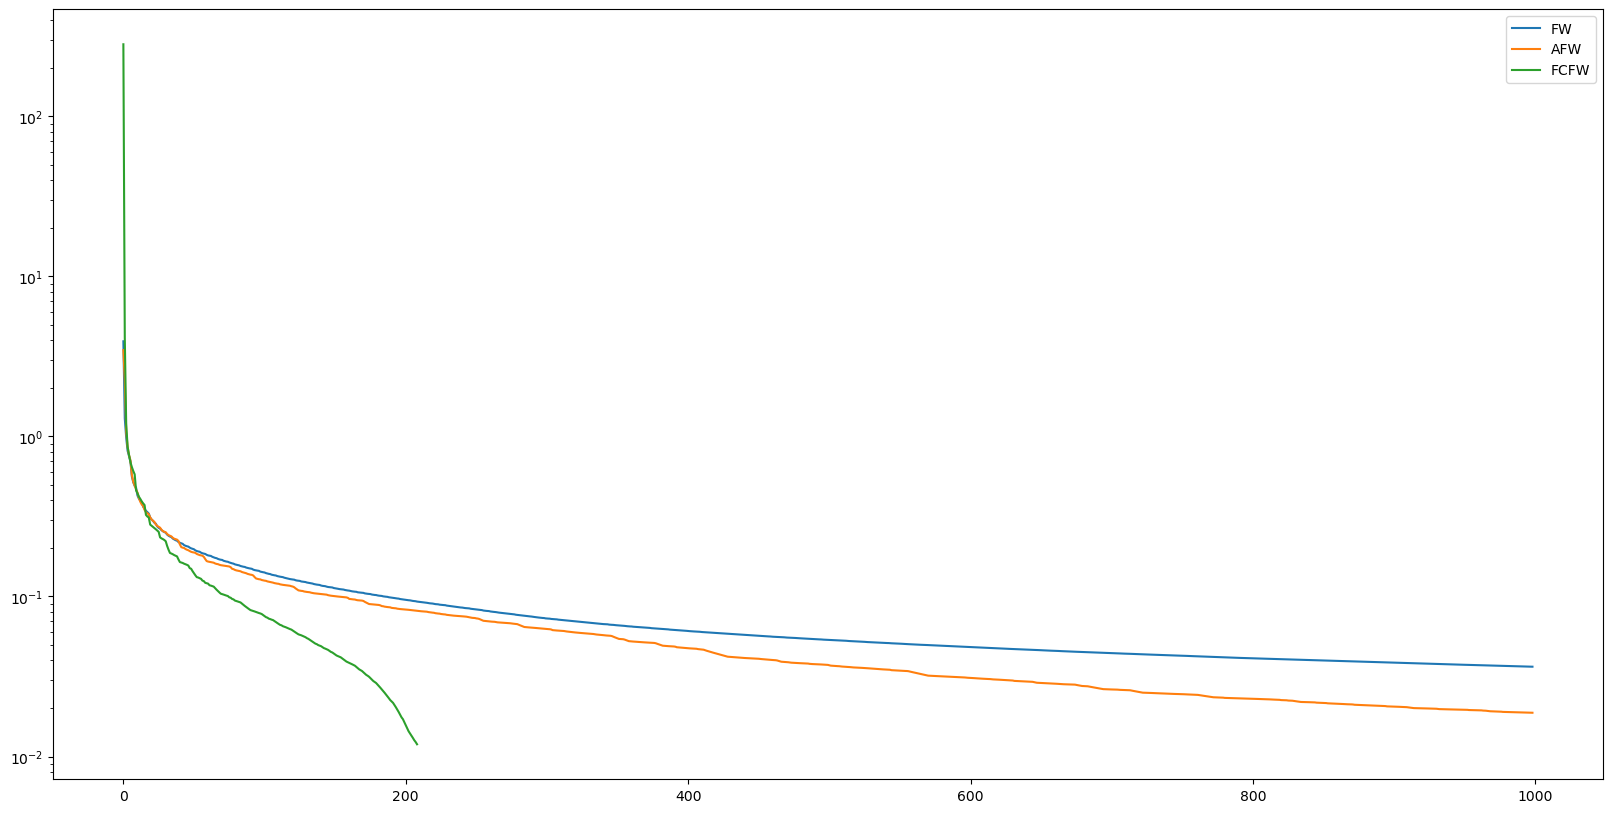

In [395]:
plt.plot(grad_list_fw, label="FW")
plt.plot(grad_list_afw, label="AFW")
plt.plot(grad_list_fcfw, label="FCFW")
plt.legend()
plt.yscale("log")

In [396]:
def compute_missing_indices(best_indices, n):
    best_i_sorted = np.sort(best_indices[:, 0])
    missing_indices = []
    duplicate_indices = []
    pointer = 0
    
    for i in range(n):            
        while pointer < len(best_i_sorted) and best_i_sorted[pointer] < i:
            duplicate_indices.append(int(best_i_sorted[pointer]))
            pointer += 1
        if pointer == len(best_i_sorted):
            missing_indices = missing_indices + [k for k in range(i, n)]
            break
        if best_i_sorted[pointer] > i:
            missing_indices.append(i)
        elif best_i_sorted[pointer] == i:
            pointer += 1
    return missing_indices, duplicate_indices

compute_missing_indices(best_indices_eta_fcfw, n)

([], [0, 1, 16, 18, 22, 37, 70, 73, 112, 196])

In [397]:
def build_final_solution(n, y_array, best_indices_eta):
    y_final = np.zeros(n)

    for i in range(n):
        matching_indices = [(j,k,eta) for (j, k, eta) in best_indices_eta if i == j]
        len_matching_indices = len(matching_indices)
        sum_etas = sum([eta for (j, k, eta) in matching_indices])

        for (j, k, eta) in matching_indices:
            #print(k, k)
            y_final[i] += 1/sum_etas * eta * y_array[int(j), int(k)]

    return y_final

def build_final_solution_fcfw(n, y_array, opt_lambda, best_indices_eta):
    y_final = np.zeros(n)
    y_final_max = np.zeros(n)

    for i in range(n):
        matching_indices = [(index, j, k, eta) for index, (j, k, eta) in enumerate(best_indices_eta) if i == j]
        sum_lambda = sum([opt_lambda[int(index)] for (index, j, k, eta) in matching_indices])

        

        max_candidate = -1

        for (index, j, k, eta) in matching_indices:
            #print(1/sum_lambda * opt_lambda[index])
            y_final[i] += 1/sum_lambda * opt_lambda[index] * y_array[int(j), int(k)]
            #y_final[i] += opt_lambda[index] * y_array[int(j), int(k)]
            if opt_lambda[index] > max_candidate:
                max_candidate = opt_lambda[index]
                y_final_max[i] = y_array[int(j), int(k)]
            if y_final[i] > 1 - 1e-5:
                y_final[i] = 1
            if y_final_max[i] > 1 - 1e-5:
                y_final_max[i] = 1

            if len(matching_indices) > 1:
                print(opt_lambda[index])
                

    return y_final, y_final_max

def check_cost(n, y_array, opt_lambda, best_indices_eta):
    cost=0
    
    for i in range(n):
        matching_indices = [(index, j,k,eta) for index, (j, k, eta) in enumerate(best_indices_eta) if i == j]
        #sum_lambda = sum([opt_lambda[int(j)] for (j, k, eta) in matching_indices if j==i])
        #print(len(matching_indices))

        for (index, j, k, eta) in matching_indices:
            #print(j, k)
            cost += opt_lambda[index] * f_value(y_array[int(j), int(k)])

    return cost

In [398]:
y_final, y_final_max = build_final_solution_fcfw(n, y_array_small, opt_lambda, best_indices_eta_fcfw)
check_cost(n, y_array_small, opt_lambda, best_indices_eta_fcfw)

-1.1645461747700203e-09
0.004982936380196293
0.000247237670274905
0.004659433819889138
1.2624451553588933e-09
0.004913574249824922
-1.0302238263870667e-09
0.005525892571012173
1.1379411735817913e-10
0.004907209889751887
-1.660361734386051e-09
0.004893301078904788
-1.9351134722400687e-09
0.005918264232166855
1.8096723416669014e-09
0.004912994462966281
-4.87317943677866e-07
0.004924791110413971
1.8503264133240258e-10
0.0053759452041264475


0.45109632483194173

In [399]:
cost(y_final), cost(y_final_max), cost(x_star)

(93, 92, 111)

In [401]:
y_final -  y_final_max

array([ 0.00000000e+00, -5.03880626e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.56930040e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.31891680e-08,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [269]:
np.linalg.norm(np.clip(A @ y_final - b, 0, None) / np.linalg.norm(b))

0.0

In [258]:
def run_experiments(max_iter=n+m):
    nb_iters = [iter for iter in range(n, max_iter+1)]
    costs = []
    infeasibility = []
    for nb_iter in nb_iters:
        print(f"For {nb_iter} iterations : ")
        z_T, best_indices_eta_fcfw, grad_list_fcfw, opt_lambda, V_matrix = fc_frank_wolfe2(z_K, nb_iter, A, b, y_array_small)
        print(compute_missing_indices(best_indices_eta_fcfw, n))
        y_final = build_final_solution_fcfw(n, y_array_small, opt_lambda, best_indices_eta_fcfw)
        costs.append(cost(y_final))
        infeasibility.append(np.linalg.norm(A @ y_final - b)/np.linalg.norm(b))

    return nb_iters, costs, infeasibility        

In [175]:
nb_iters, costs, infeasibility = run_experiments(300)

For 200 iterations : 
157 1
At iteration 20, grad_norm = 0.29559672188892233


/tmp/ipykernel_15627/3070021415.py:72: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  opt_lambda = np.linalg.lstsq(V_matrix, -p[:-1] + z_star)[0]


At iteration 40, grad_norm = 0.15869256265453585
At iteration 60, grad_norm = 0.120232392463711
At iteration 80, grad_norm = 0.09182107883388176
At iteration 100, grad_norm = 0.07378580569226009
At iteration 120, grad_norm = 0.06032813102277377
At iteration 140, grad_norm = 0.04837271474030245
At iteration 160, grad_norm = 0.03731944841504616
At iteration 180, grad_norm = 0.026149496423716126
([], [])
For 201 iterations : 
118 0
([], [56])
For 202 iterations : 
199 0
([], [28, 126])
For 203 iterations : 
167 1
([], [11, 26, 130])
For 204 iterations : 
189 0
([], [28, 53, 126, 194])
For 205 iterations : 
125 0
At iteration 41, grad_norm = 0.16053490259513356
At iteration 82, grad_norm = 0.09196066561187384
At iteration 123, grad_norm = 0.05948171780762151
At iteration 164, grad_norm = 0.03608251861159633
([], [28, 38, 53, 126, 194])
For 206 iterations : 
37 0
([], [28, 39, 53, 70, 126, 194])
For 207 iterations : 
144 0
([], [28, 37, 39, 68, 70, 126, 194])
For 208 iterations : 
122 0
([]

IndexError: index 285 is out of bounds for axis 0 with size 285

Text(0.5, 1.0, 'Costs and relative infeasibility as a function of the number of iterations of the second FW for n = 200 and m = 40')

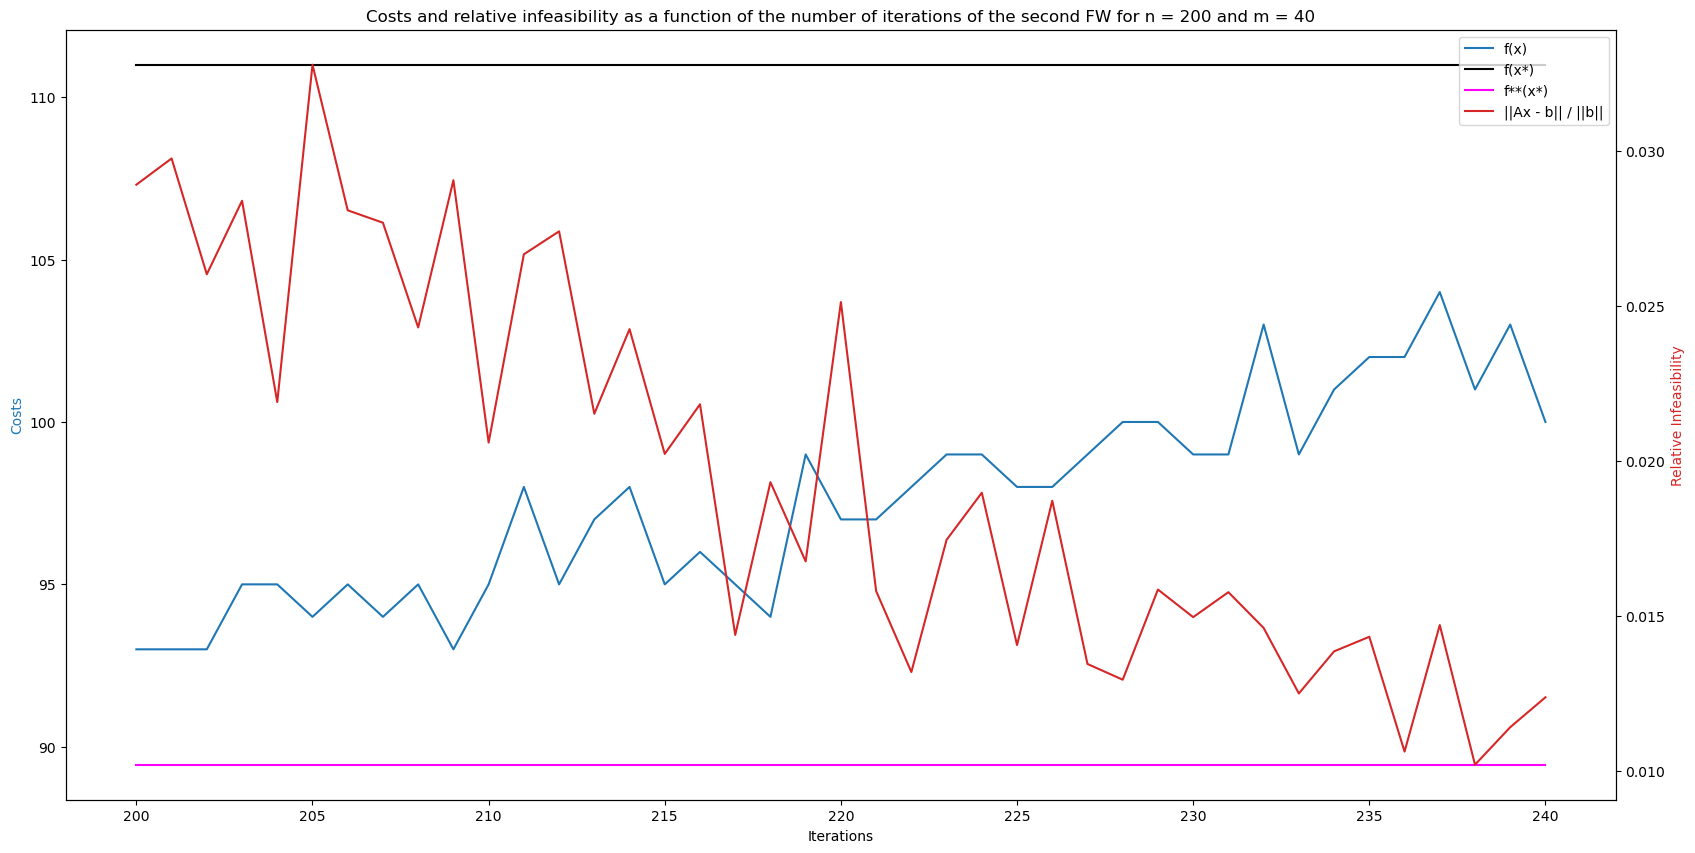

In [169]:
fig, ax1 = plt.subplots()

# Plotting costs on the left y-axis
ax1.plot(nb_iters, costs, color='tab:blue', label='f(x)')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Costs', color='tab:blue')
ax1.plot(nb_iters, [cost(x_star) for k in nb_iters], color="black", label="f(x*)")
ax1.plot(nb_iters, [cost_relaxed(x_star) for k in nb_iters], color="magenta", label="f**(x*)")


# Creating the second axis (right) and sharing the x-axis
ax2 = ax1.twinx()

# Plotting infeasibility on the right y-axis
ax2.plot(nb_iters, infeasibility, color='tab:red', label='||Ax - b|| / ||b||')
ax2.set_ylabel('Relative Infeasibility', color='tab:red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

plt.title(f"Costs and relative infeasibility as a function of the number of iterations of the second FW for n = {n} and m = {m}")

In [338]:
def align(d, d_hat):
    if np.linalg.norm(d_hat) != 0:
        return d.dot(d_hat) / (np.linalg.norm(d) * np.linalg.norm(d_hat))
    else:
        return -1


def boosted_frank_wolfe2(z_K, T, A, b, y_array, P, delta):
    m, n = A.shape
    K = y_array.shape[1]

    grad_list = []
    active_set = []

    #compute z_star for convenience
    z_star = np.zeros(1 + m + n)
    z_star[:m+1] = z_K/n
    z_star[m+1:] = np.ones(n)/n

    f_values = np.array([[f_value(y_array[i, k]) for k in range(K)] for i in range(n)])
    #pick index 0 for the first one
    first_K = np.random.randint(K)
    first_i = np.random.randint(n)
    print(first_i, first_K)
    z_t = build_vector_from_indices(first_i, first_K, A, y_array)
    iz, kz = LMO(z_t, A, y_array, f_values) 
    z_t = build_vector_from_indices(iz, kz, A, y_array)
    
    active_set.append((iz, kz))
    

    V_matrix_list = [z_t]
    prod_etat = 1

    
    for t in range(T):
        grad_t = z_t - z_star
        d_p = np.zeros(n+m+1)
        Lambda_t = 0
        flag = False
        last_iter = P

        grad_list.append(np.linalg.norm(grad_t))

        if t%(T/10) == 0:
            print(f"At iteration {t}, grad_norm = {np.linalg.norm(grad_t)}")
            print(prod_etat)


        for p in range(P):
            r_p = - grad_t - d_p
            i_v_p, k_v_p = LMO(-r_p, A, y_array, f_values)
            v_p = build_vector_from_indices(i_v_p, k_v_p, A, y_array)
            u_p = 0
            u_p_cand1 = v_p - z_t
            u_p_cand2 = -d_p / np.linalg.norm(d_p)
            option_chosen = 0
            if u_p_cand1.dot(r_p) > u_p_cand2.dot(r_p) or np.linalg.norm(d_p) == 0:
                u_p = u_p_cand1
                option_chosen = 1
            else:
                u_p = u_p_cand2
                option_chosen = 2
            #print(option_chosen)
            lambda_p = r_p.dot(u_p) / u_p.dot(u_p)
            d_p_prime = d_p + lambda_p * u_p
            #print(align(-grad_t, d_p_prime) -  align(-grad_t, d_p))
            if align(-grad_t, d_p_prime) - align(-grad_t, d_p) >= delta:
                d_p1 = d_p_prime
                if option_chosen == 1:
                    Lambda_t += lambda_p
                elif option_chosen==2:
                    #print("here")
                    Lambda_t *= (1 - lambda_p / np.linalg.norm(d_p))
                d_p = d_p1
            else:
                flag = True
                last_iter = p
                #print(f"breaking at p = {p}")
                break
        if flag:
            Pt = last_iter
        else:
            Pt = P
        g_t = d_p / Lambda_t
        gamma_t = compute_optimal_stepsize(z_t, z_star, g_t, 1)
        prod_etat *= (1 - align(-grad_t, g_t))
        etat = align(-grad_t, g_t)
        #gamma_t = min(1, etat*np.linalg.norm(grad_t) / np.linalg.norm(g_t))
        #print(gamma_t, prod_etat)
        z_t = z_t + gamma_t * g_t
    return z_t, grad_list

In [339]:
z_T, grad_list_bfw = boosted_frank_wolfe2(z_K, 1000, A, b, y_array_small, 100, 0.001)

198 1
At iteration 0, grad_norm = 1.9615317775520822
1


/tmp/ipykernel_15627/4228168719.py:56: RuntimeWarning: divide by zero encountered in divide
  u_p_cand2 = -d_p / np.linalg.norm(d_p)
/tmp/ipykernel_15627/4228168719.py:56: RuntimeWarning: invalid value encountered in divide
  u_p_cand2 = -d_p / np.linalg.norm(d_p)


At iteration 100, grad_norm = 0.009577355200232165
4.687934376545341e-13
At iteration 200, grad_norm = 0.006755680526840593
9.31417245365092e-17
At iteration 300, grad_norm = 0.0054411527884269785
1.1618570316165156e-19
At iteration 400, grad_norm = 0.004646619529695299
4.076345985133214e-22
At iteration 500, grad_norm = 0.004097418602332471
2.6052477781736624e-24
At iteration 600, grad_norm = 0.0037042611498054666
2.862757662117673e-26
At iteration 700, grad_norm = 0.0034032264936975968
4.629436926511321e-28
At iteration 800, grad_norm = 0.0031444687307045998
8.726392530305056e-30
At iteration 900, grad_norm = 0.0029143467413256727
1.7597271180817146e-31


In [340]:
grad_list_bfw = grad_list

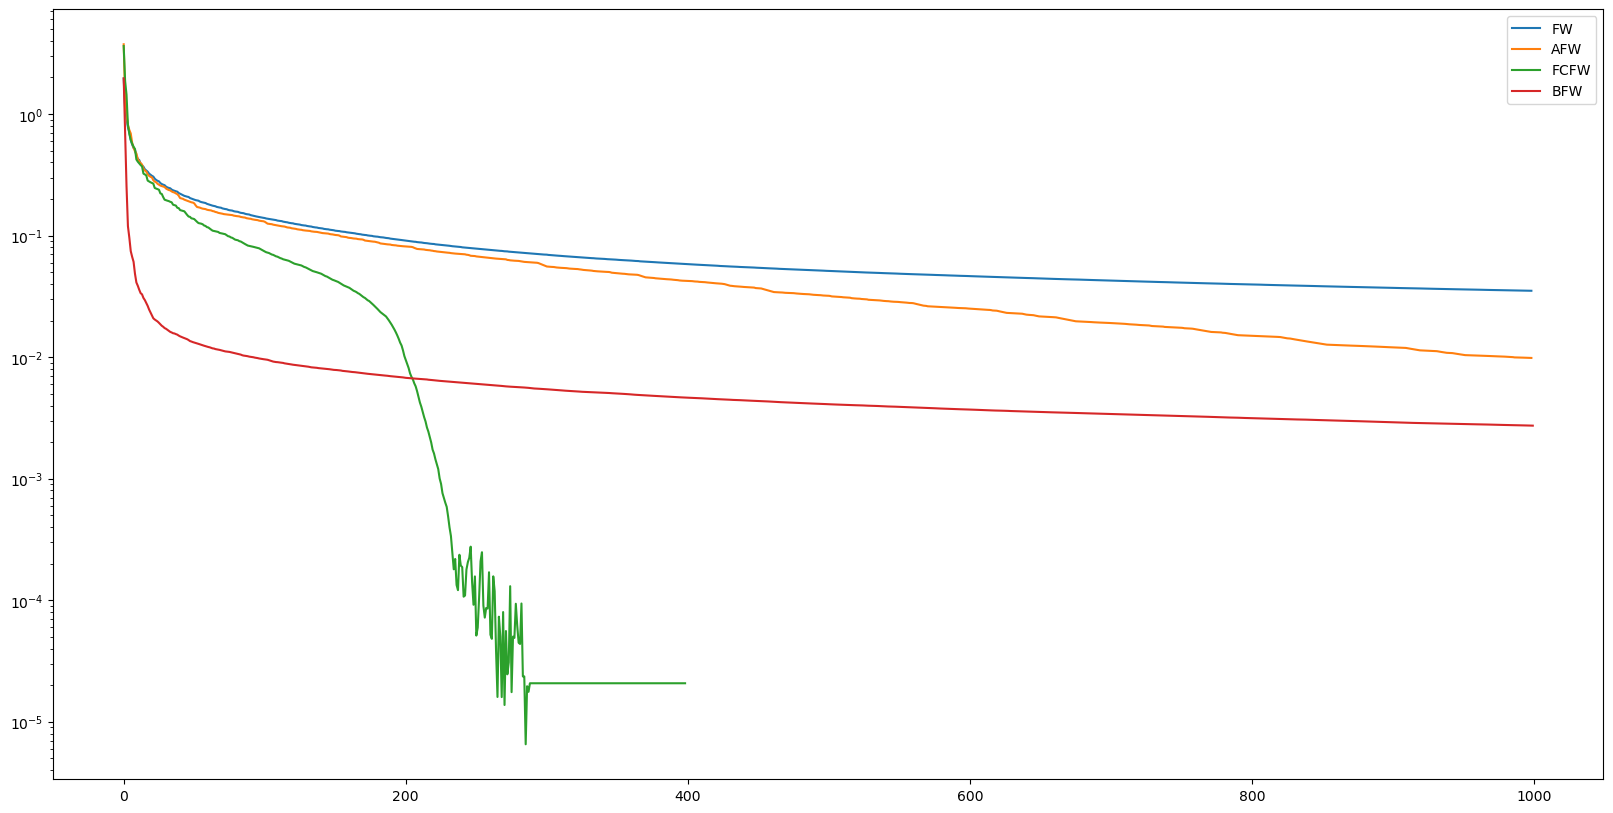

In [347]:
plt.plot(grad_list_fw, label="FW")
plt.plot(grad_list_afw, label="AFW")
plt.plot(grad_list_fcfw, label="FCFW")
plt.plot(grad_list_bfw, label="BFW")
plt.legend()
plt.yscale("log")

In [349]:
np.min(opt_lambda)

-0.0008770580487980786